# 导入库

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

# 构建类似Madelon数据集

The Madelon-like data set that we will generate will contain 100 features, where 10 of them will be informative, 50 will be redundant (but informative), 25 of them will be repeated, and 15 will be useless since they will be filled with random noise. In total, we will have 1000 samples. To add a bit more noise to the data, we will randomly flip 5 percent of the labels. The second group of features will contain 3 critical important features. The critical important features by design should be challenging to select by automated feature selection algorithms. Finally, the last group of features will simply be the Madelon-like and the critical features added together into a bigger data set.

In [2]:
# Define the number of features for each type
n_features = 100    # 总特征数
n_informative = 10  # 有用特征数
n_redundant = 50    # 冗余特征数
n_repeated = 25     # 重复特征数
n_useless = 15      # 无用特征数

# Create Labels
informative_labels = [f'Informative {ii}' for ii in range(1, n_informative + 1)]
redundant_labels = [f'Redundant {ii}' for ii in range(n_informative + 1, n_informative + n_redundant + 1)]
repeated_labels = [f'Repeated {ii}' for ii in range(n_informative + n_redundant+ 1, n_informative + n_redundant + n_repeated + 1)]
useless_labels = [f'Useless {ii}' for ii in range(n_informative + n_redundant + n_repeated + 1, n_features + 1)]
labels = informative_labels + redundant_labels + repeated_labels + useless_labels

# Get data
X_madelon, y_madelon = make_classification(n_samples = 1000, n_features = n_features,
                           n_informative = n_informative,
                           n_redundant = n_redundant , n_repeated = n_repeated,
                           n_clusters_per_class = 2, class_sep = 0.5, flip_y = 0.05,
                           random_state = 42, shuffle = False)


# Numpy array to pandas dataframe and series
X_madelon = pd.DataFrame(X_madelon, columns = labels)

# 构建3个关键特征

In [3]:
def randn_skew_fast(N, alpha=0.0, loc=0, scale=1.0):
    """
    Created a skewed distribution by randomly drawing from a skewed probability 
    densiy function.
    
    
    Parameters
    ----------
     N: int
        Number of points
    
    alpha: float
        Value describing the skeweness of the distribution. 
    
    loc: float
        Value describing the mean value of the skewed distribution
    
    scale: float
        Value describing the width of the skewed distribution
    
    
    Author Information
    ------------------
    jamesj629: <https://stackoverflow.com/users/266208/jamesj629>
    
    Source to original function: 
    <https://stackoverflow.com/questions/36200913/generate-n-random-numbers-from-a-skew-normal-distribution-using-numpy>
    """
    sigma = alpha / np.sqrt(1.0 + alpha**2) 
    u0 = np.random.randn(N)
    v = np.random.randn(N)
    u1 = (sigma*u0 + np.sqrt(1.0 - sigma**2)*v) * scale
    u1[u0 < 0] *= -1
    u1 = u1 + loc
    return u1

In [4]:
# Set critical features distribution parameters
No_Critical_Features = 3
NUM_SAMPLES = 1000
SKEW_PARAMS = [0, 0, 0]
AVERAGE = [-10, 0, 10]
SEEDS = [42, 148, 526]
critical_features = []

# Create critical features
for ii in range(No_Critical_Features):
    # Set random seed
    np.random.seed(SEEDS[ii])
    
    # Set skewness and average value
    alpha_skew = SKEW_PARAMS[ii]
    average = AVERAGE[ii]
    
    # Get critical feature
    X_temp = randn_skew_fast(N = NUM_SAMPLES, alpha = alpha_skew, loc = average)
    
    # Append to critical feature list
    critical_features.append(X_temp)

在将关键特征加入数据集前，我们需要定义`y_critical`目标，通过对每个关键特征设置阈值来决定是正例或反例。选择这些阈值使得每个关键特征包含95%的正例和5%的反例。最终，通过将这些关键特征的目标值相乘得到`y_critical`


In [5]:
# Get critical labels
y_critical_1 = critical_features[0] < -8.3
y_critical_2 = critical_features[1] > -1.6
y_critical_3 = critical_features[2] > 8.3

# Save targets into a list
y_critical_targets = [y_critical_1, y_critical_2, y_critical_3]

# Define y_critical 
y_critical = y_critical_1*y_critical_2*y_critical_3*1

## 可视化关键特征的分布

/Users/qianchunqiang/miniforge3/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


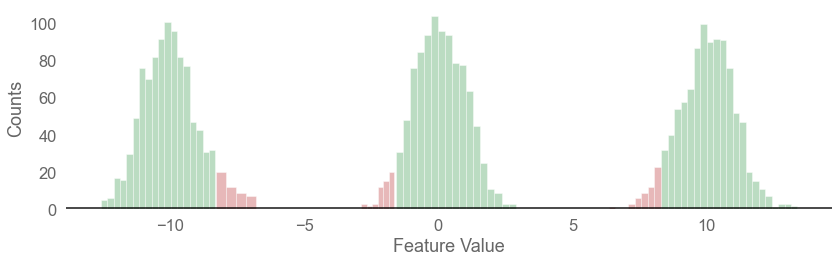

In [6]:
# Set graph style
sns.set(font_scale = 1.5)
sns.set_style({'axes.facecolor': '1.0', 'axes.edgecolor': '0.85', 'grid.color': '0.85',
               'grid.linestyle': '-', 'axes.labelcolor': '0.4', 'xtick.color': '0.4',
               'ytick.color': '0.4', 'axes.grid': False})

# Set figure size
f, ax = plt.subplots(figsize=(12, 4))

for ii in range(No_Critical_Features):
    # Get critical features
    X_temp = critical_features[ii]
    y_temp = y_critical_targets[ii]
    
    # Get indices for true cases
    X_true = [X_temp[jj] for jj in range(len(y_temp)) if y_temp[jj] == 1]
    X_false = [X_temp[jj] for jj in range(len(y_temp)) if y_temp[jj] == 0]
    
    # Plot true values
    sns.distplot(X_true, color = 'g',  kde=False, ax = ax)
    sns.distplot(X_false, color = 'r',  kde=False, ax = ax)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Set axis labels
plt.xlabel('Feature Value')
plt.ylabel('Counts')

 # Tight layout
plt.tight_layout()

# Save figure
plt.savefig(f'Critical Feature Distribution.png', dpi = 1080)

## 将关键特征合进数据集

In [7]:
# Define critical feature labels
critical_feature_labels =  [f'Critical {ii}' for ii in range(1, No_Critical_Features + 1)]

# Convert list to numpy arrays
X_critical = np.asarray(critical_features, dtype=np.float64).T
X_critical = pd.DataFrame(X_critical, columns = critical_feature_labels)

# Create feature matrix
X_all = pd.concat([X_madelon, X_critical], axis = 1)

# Create target
y_all = np.array([y_madelon[ii] * y_critical[ii] for ii in range(len(y_madelon))])

特征分布情况：  
1. Informative features — Columns 1–10: These features are highly related to the outcome and ideally should be the features you select.
2. Redundant features — Columns 11–60: These features are made by linearly combining the informative features with different random weights. You can think of these as engineered features.
3. Repeated features — Columns 61–85: These features are drawn randomly from either the informative or redundant features.
4. Useless features — Columns 86–100: These features are filled with random noise.
5. Critically important features — Columns 101–103: These features have Gaussian distribution and we will demand that they absolutely need to be included in the selected features.


# 划分数据集--训练集和测试集

In [8]:
# Split the X_all and y_all
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, 
                                                                    test_size = 0.30,
                                                                    random_state = 42)

# 探索性数据分析（Exploratory Data Analysis）
  
我们将分析特征间的相关性

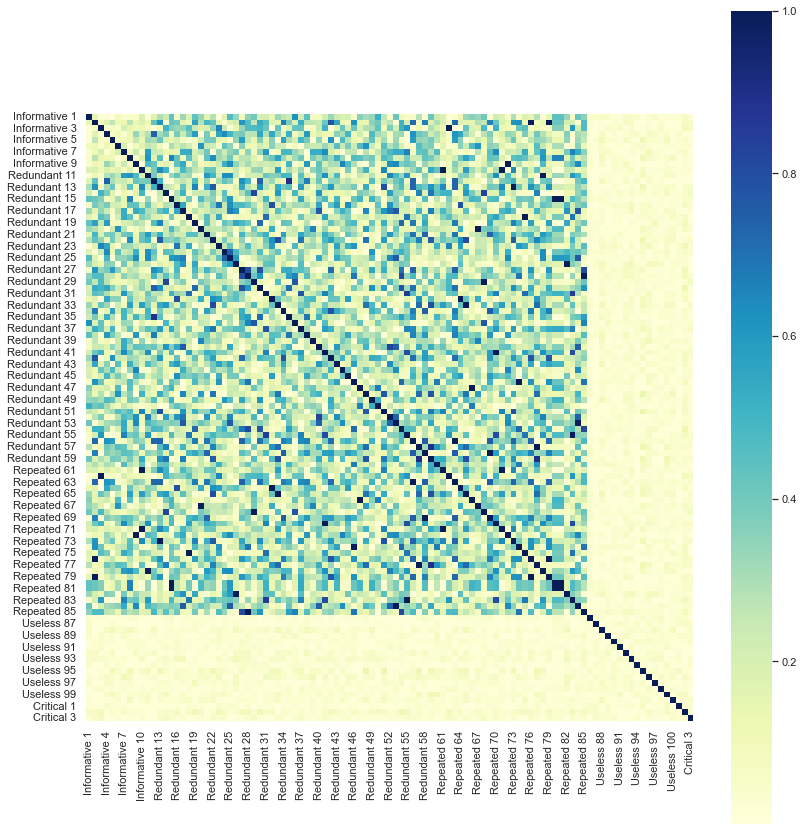

In [9]:
# Make correlation matrix
corr_matrix = X_all_train.corr(method = 'spearman').abs()

# Set font scale
sns.set(font_scale = 1)

# Set the figure size
f, ax = plt.subplots(figsize=(12, 12))

# Make heatmap
sns.heatmap(corr_matrix, cmap= 'YlGnBu', square=True, ax = ax)

# Tight layout
f.tight_layout()

# Save figure
f.savefig('correlation_matrix.png', dpi = 1080)

可以看出：
1. 有效特征间没有相关性
2. 冗余特征间有中度相关性
3. 重复特征间有较高相关性
4. 无用特征和关键特征与其他特征间没有相关性

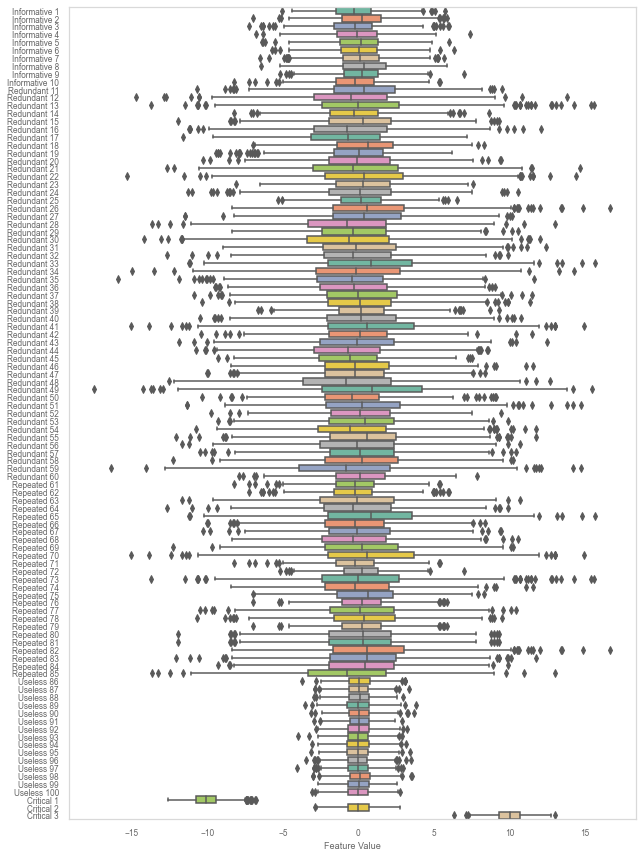

In [10]:
# Set graph style
sns.set(font_scale = 0.75)
sns.set_style({'axes.facecolor': '1.0', 'axes.edgecolor': '0.85', 'grid.color': '0.85',
               'grid.linestyle': '-', 'axes.labelcolor': '0.4', 'xtick.color': '0.4',
               'ytick.color': '0.4', 'axes.grid': False})

# Create box plots based on feature type

# Set the figure size
f, ax = plt.subplots(figsize=(9, 12))
sns.boxplot(data=X_all_train, orient="h", palette="Set2")

# Set axis label
plt.xlabel('Feature Value')

# Tight layout
f.tight_layout()

# Save figure
f.savefig(f'Box Plots.png', dpi = 1080)

从上图可以看出，大部分特征都包含异常值。并且，所有类Madelon特征均值为零的高斯分布。关键特征的均值各不相同

# 特征筛选

![constantFeatures]('./pics/constantFeatures.webp')